In [2]:
import pandas as pd
import os
import torch
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from tqdm import tqdm  # Importer tqdm pour la barre de progression


In [3]:
# Charger les données
train_df = pd.read_csv("../preprocessing_for_CLIP/train.csv")
test_texts_df = pd.read_csv("../preprocessing_for_CLIP/test_texts.csv")
test_labels_df = pd.read_csv("../preprocessing_for_CLIP/test_labels.csv")
train_folder_path = "../dataset/TRAINING"
test_folder_path = "../dataset/test"


# Compter le nombre d'exemples dans chaque classe
print("Répartition des labels dans le dataset d'entraînement :\n", train_df["label"].value_counts())

Répartition des labels dans le dataset d'entraînement :
 label
0    5000
1    5000
Name: count, dtype: int64


In [4]:
# Charger le modèle CLIP et le processor pour prétraiter les images et textes
print("Chargement du modèle CLIP...")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
print("Modèle CLIP chargé !")

Chargement du modèle CLIP...
Modèle CLIP chargé !


In [5]:
import torchvision.transforms as transforms

def image_path_to_tensor(image_path, folder_path):
    # Charger l'image avec PIL
    full_image_path = os.path.join(folder_path, image_path)
    image = Image.open(full_image_path).convert("RGB")
    image_np = np.array(image, dtype=np.float32) / 255.0 
    # Vérifier si les valeurs sont bien dans la plage [0, 1]
    if np.any(image_np < 0) or np.any(image_np > 1):
        print(f"Attention: image avec valeurs hors de la plage [0, 1] dans {image_path}")
    # Utiliser le préprocesseur CLIP pour transformer l'image
    inputs = processor(images=image, return_tensors="pt", padding=True, do_rescale=False)  # Désactiver la mise à l'échelle

    return inputs['pixel_values'][0]  # Retourne le tensor de l'image

def get_clip_embeddings(texts, images):
    # Prétraiter les textes séparément
    text_inputs = processor(text=texts, return_tensors="pt", padding=True, truncation=True, max_length=77)
    
    # Normaliser les images dans la plage [0, 1]
    # La normalisation est effectuée à la place avant de les transmettre au préprocesseur CLIP
    images_normalized = []
    for image in images:
        # Assurez-vous que les valeurs sont dans la plage [0, 1] avant d'être envoyées au modèle
        if isinstance(image, np.ndarray):
            image = np.clip(image / 255.0, 0.0, 1.0)  # Normaliser et contraindre entre [0, 1]
        else:
            image = np.clip(np.array(image) / 255.0, 0.0, 1.0)
        images_normalized.append(image)

    # Prétraiter les images séparément
    image_inputs = processor(images=images_normalized, return_tensors="pt", padding=True, do_rescale=False)  # Désactiver la mise à l'échelle

    with torch.no_grad():
        # Obtenir les embeddings des textes et des images
        text_embeds = model.get_text_features(**text_inputs)
        image_embeds = model.get_image_features(**image_inputs)

    return text_embeds, image_embeds

In [6]:
# Dataset pour charger les textes et les images
class MemeDataset(Dataset):
    def __init__(self, texts, images, labels):
        self.texts = texts
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        image = self.images[idx]
        label = self.labels[idx]
        return text, image, label

In [7]:
# Charger les images (supposons qu'elles sont en format chemin d'image ou déjà converties en tensors)
print("Chargement des images de train")
train_images = [image_path_to_tensor(image_path, train_folder_path) for image_path in train_df["file_name"]]
print("Chargement des images de test")
test_images = [image_path_to_tensor(image_path, test_folder_path) for image_path in test_texts_df["file_name"]]


Chargement des images de train
Chargement des images de test


In [8]:
# Préparer les datasets
print("Préparation des datasets...")
train_texts = train_df["text"].tolist()
train_labels = train_df["label"].tolist()

test_texts = test_texts_df["text"].tolist()
test_labels = test_labels_df["label"].tolist()

train_dataset = MemeDataset(train_texts, train_images, train_labels)
test_dataset = MemeDataset(test_texts, test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)
print("Préparation des datasets terminée !")

Préparation des datasets...
Préparation des datasets terminée !


In [9]:
# Extraire les embeddings et entraîner le modèle
def extract_embeddings(loader):
    embeddings = []
    labels = []
    # Ajouter tqdm pour la barre de progression
    for texts, images, label in tqdm(loader, desc="Extraction des embeddings", leave=False):
        text_embeds, image_embeds = get_clip_embeddings(texts, images)
        combined_embeds = torch.cat((text_embeds, image_embeds), dim=-1).numpy()  # Combine embeddings
        embeddings.append(combined_embeds)
        labels.append(label.numpy())
    return np.vstack(embeddings), np.hstack(labels)

In [10]:
# Chemins des fichiers pour sauvegarder les embeddings
train_embeddings_file = "train_embeddings.npz"
test_embeddings_file = "test_embeddings.npz"

# Vérifier si les fichiers existent déjà
if os.path.exists(train_embeddings_file) and os.path.exists(test_embeddings_file):
    print("Chargement des embeddings sauvegardés...")
    train_data = np.load(train_embeddings_file)
    test_data = np.load(test_embeddings_file)
    X_train, y_train = train_data["X"], train_data["y"]
    X_test, y_test = test_data["X"], test_data["y"]
    print("Chargement des embeddings terminé !")
else:
    print("Extraction des embeddings d'entraînement...")
    X_train, y_train = extract_embeddings(train_loader)
    print("Extraction des embeddings de test...")
    X_test, y_test = extract_embeddings(test_loader)
    
    print("Extraction des embeddings terminée !")
    
    # Sauvegarde des embeddings
    np.savez_compressed(train_embeddings_file, X=X_train, y=y_train)
    np.savez_compressed(test_embeddings_file, X=X_test, y=y_test)
    print("Embeddings sauvegardés !")

Chargement des embeddings sauvegardés...
Chargement des embeddings terminé !


In [91]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
from transformers import get_scheduler

dropout = 0.5  # Taux de dropout

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Définition du modèle de réseau de neurones
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, output_dim=1, dropout=dropout):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)  # Normalisation de lot
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)  # Normalisation de lot
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)  # Application de la normalisation de lot
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)  # Application de la normalisation de lot
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Initialisation du modèle
device = "cuda" if torch.cuda.is_available() else "cpu"
input_dim = 512 * 2  # Taille des embeddings CLIP (texte + image)
model = NeuralNet(input_dim).to(device)

# Entraînement du réseau de neurones
num_epochs = 450
batch_size = 256
lr = 1e-5

train_steps_per_epoch = len(train_loader)
total_steps = num_epochs * train_steps_per_epoch

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

schedule = False
scheduler = get_scheduler(
    "cosine",  # ou "cosine"
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [92]:
from tqdm import tqdm

# Convertir en tenseurs PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

# Stocker les pertes pour les visualiser plus tard
train_losses = []

print("Entraînement du réseau de neurones...")
progress_bar = tqdm(range(num_epochs), desc="Progression", unit="epoch")

for epoch in progress_bar:
    model.train()
    optimizer.zero_grad()

    # Prédiction et calcul de la perte
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Stocker la perte
    train_losses.append(loss.item())

    # Rétropropagation
    loss.backward()
    optimizer.step()
    
    if schedule:
        # Mettre à jour le scheduler
        scheduler.step()

    # Mettre à jour tqdm avec la perte actuelle
    progress_bar.set_postfix(loss=loss.item())

print("Entraînement du réseau de neurones terminé !")

# Évaluation sur les données de test
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_tensor).cpu().numpy().round()
    y_pred_test = model(X_test_tensor).cpu().numpy().round()

Entraînement du réseau de neurones...


Progression:   0%|          | 0/450 [00:00<?, ?epoch/s]

Progression: 100%|██████████| 450/450 [02:06<00:00,  3.55epoch/s, loss=0.35] 

Entraînement du réseau de neurones terminé !


In [93]:
# Calculer les métriques
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

train_f1 = f1_score(y_train, y_pred_train, average='binary')
test_f1 = f1_score(y_test, y_pred_test, average='binary')

print(f"Train Accuracy: {train_acc}")
print(f"Test Accuracy: {test_acc}")
print(f"Train F1 Score: {train_f1}")
print(f"Test F1 Score: {test_f1}")

Train Accuracy: 0.8628
Test Accuracy: 0.717
Train F1 Score: 0.8613020622725435
Test F1 Score: 0.7583262169086251


In [94]:
# Sauvegarde des résultats
import csv
import os
from collections import Counter

# Fonction pour formater les dictionnaires contenant des np.int64
def format_dict(d):
    return " , ".join(f"{int(k)} : {int(v)}" for k, v in d.items())

# Distribution des prédictions
train_counts = Counter(y_pred_train.flatten())
test_counts = Counter(y_pred_test.flatten())

# Hyperparamètres et résultats
params = {
    "num_epochs": num_epochs,
    "batch_size": batch_size,
    "dropout": dropout,
    "lr": lr,
    "schedule": schedule,
    "loss": "BCELoss",
    "train_acc": round(train_acc, 4),
    "train_f1_score": round(train_f1, 4),
    "test_acc": round(test_acc, 4),
    "test_f1_score": round(test_f1, 4)
}

# Sauvegarde dans un fichier CSV
output_file = "hyperparameters_results_rn.csv"

if os.path.exists(output_file):
    with open(output_file, mode='r', newline='', encoding='utf-8-sig') as file:
        reader = csv.reader(file)
        rows = list(reader)

    header = rows[0]
    existing_value_columns = [col for col in header[1:] if col.startswith("valeurs_")]
    new_col_name = f"valeurs_{len(existing_value_columns) + 1}" if existing_value_columns else "valeurs_1"
    header.append(new_col_name)

    for i in range(1, len(rows)):
        key = rows[i][0]
        rows[i].append(params.get(key, ""))

    with open(output_file, mode='w', newline='', encoding='utf-8-sig') as file:
        writer = csv.writer(file)
        writer.writerows(rows)
else:
    with open(output_file, mode='w', newline='', encoding='utf-8-sig') as file:
        writer = csv.writer(file)
        writer.writerow(["Hyperparamètres et Résultats", "valeurs_1"])
        for key, value in params.items():
            writer.writerow([key, value])

print(f"Données exportées avec succès dans {output_file} !")

Données exportées avec succès dans hyperparameters_results_rn.csv !


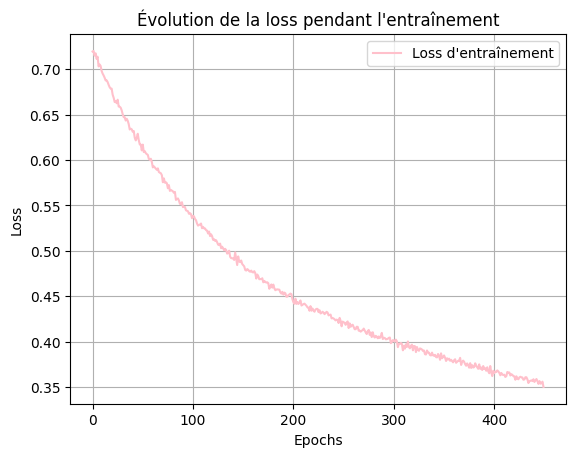

In [98]:
import matplotlib.pyplot as plt

# Courbe d'évolution de la loss
plt.plot(range(num_epochs), train_losses, label="Loss d'entraînement", color="pink")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Évolution de la loss pendant l'entraînement")
plt.legend()
plt.grid()
plt.show()